로지스틱회귀(Logistic Regression) : 타이타닉 생존자 예측

목표: 타이타닉 승객 데이터셋을 이용하여 생존 여부 예측

via 최효원's Jupyter Notebook

타이타닉 사고 당시 승선한 승객의 정보를 담고있는 데이터셋입니다(이름, 성별, 나이, 티켓 번호 등).

독립, 종속변수가 선형 관계에 놓여있을 때 적합하고, 다른 분류 모델과 성능을 비교하는 baseline 으로 사용되는
로지스틱 회귀 알고리즘을 데이터셋에 적용 후, 여러 정보가 실제로 승객의 생존에 어떤 영향을 미치는지 예측하기 위한 작업을 진행했습니다.

In [1]:
import pandas as pd

df = pd.read_csv('https://media.githubusercontent.com/media/musthave-ML10/data_source/main/titanic.csv')
#데이터 출처: https://media.githubusercontent.com/media/musthave-ML10
df.head()
#티켓 클래스 #이름(o) #성별(o) #나이 #함께 탑승한 형제 및 배우자 수
#함께 탑승한 부모 및 자녀 수 #티켓번호(o) #승선 항구(o) #생존여부(target)
#o -> object 변수

,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Embarked,Survived
0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,S,0
1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,C,1
2,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,S,1
3,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,S,1
4,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,S,0


In [2]:
df.info()
#total = 889 rows / 9 cols

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 889 entries, 0 to 888
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Pclass    889 non-null    int64  
 1   Name      889 non-null    object 
 2   Sex       889 non-null    object 
 3   Age       889 non-null    float64
 4   SibSp     889 non-null    int64  
 5   Parch     889 non-null    int64  
 6   Ticket    889 non-null    object 
 7   Embarked  889 non-null    object 
 8   Survived  889 non-null    int64  
dtypes: float64(1), int64(4), object(4)
memory usage: 62.6+ KB


In [4]:
df.describe().T
#Pclass = 1,2,3 총 세 가지 클래스 존재.
#Age = 대부분 승객이 젊은 층, 일부 나이 많은 승객 존재.
#SibSp, Parch = 대부분 승객이 가족을 동반하지 않고 혼자 탑승.

,count,mean,std,min,25%,50%,75%,max
Pclass,889.0,2.311586,0.834700,1.00,2.0,3.0,3.0,3.0
Age,889.0,29.315152,12.984932,0.42,22.0,28.0,35.0,80.0
SibSp,889.0,0.524184,1.103705,0.00,0.0,0.0,1.0,8.0
Parch,889.0,0.382452,0.806761,0.00,0.0,0.0,0.0,6.0
Survived,889.0,0.382452,0.486260,0.00,0.0,0.0,1.0,1.0


In [5]:
df.corr()
#변수 간 상관관계 확인

,Pclass,Age,SibSp,Parch,Survived
Pclass,1.000000,-0.336512,0.081656,0.016824,-0.335549
Age,-0.336512,1.000000,-0.232543,-0.171485,-0.069822
SibSp,0.081656,-0.232543,1.000000,0.414542,-0.034040
Parch,0.016824,-0.171485,0.414542,1.000000,0.083151
Survived,-0.335549,-0.069822,-0.034040,0.083151,1.000000


*SipSp, Parch 변수의 상관관계가 가장 크다(약 0.415)

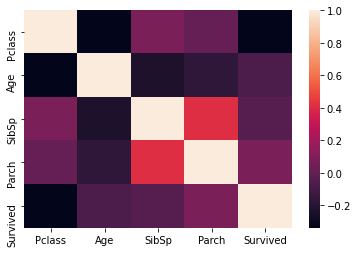

In [6]:
import matplotlib.pyplot as plt
#상관 관계 시각화를 위한 import
import seaborn as sns

sns.heatmap(df.corr())
#히트맵 생성
plt.show()

<AxesSubplot:>

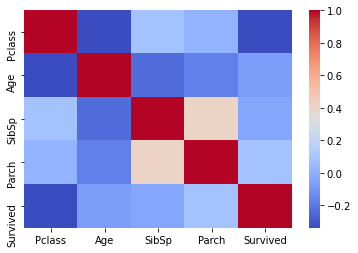

In [7]:
sns.heatmap(df.corr(), cmap = 'coolwarm')

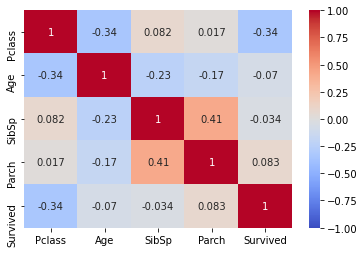

In [9]:
sns.heatmap(df.corr(), cmap = 'coolwarm', vmin = -1, vmax = 1, annot = True)
plt.show()

In [10]:
print(df.Name.nunique())
print(df.Sex.nunique())
print(df.Ticket.nunique())
print(df.Embarked.nunique())
#각 변수 고유값 확인

889
2
680
3


In [11]:
df.drop(['Name', 'Ticket'], axis = 1, inplace = True)
#이름 - 이름에 따라 사망 여부가 갈린다고 추론하기 힘듦, 제외
#티켓번호 - PClass(티켓 클래스) 변수를 이미 가지고 있으므로 제외
df.head()

,Pclass,Sex,Age,SibSp,Parch,Embarked,Survived
0,3,male,22.0,1,0,S,0
1,1,female,38.0,1,0,C,1
2,3,female,26.0,0,0,S,1
3,1,female,35.0,1,0,S,1
4,3,male,35.0,0,0,S,0


In [16]:
df = pd.get_dummies(df, columns = ['Sex', 'Embarked'], drop_first = True)
#성별, 승선 항구 변수 더미 전처리(원핫 인코딩)
df.head()

,Pclass,Age,SibSp,Parch,Survived,Sex_male,Embarked_Q,Embarked_S
0,3,22.0,1,0,0,1,0,1
1,1,38.0,1,0,1,0,0,0
2,3,26.0,0,0,1,0,0,1
3,1,35.0,1,0,1,0,0,1
4,3,35.0,0,0,0,1,0,1


In [18]:
from sklearn.model_selection import train_test_split
#데이터 분할

X = df.drop('Survived', axis = 1)
#독립 변수
y = df.Survived
#종속 변수
xtr,xt, ytr, yt = train_test_split(X, y, test_size = 0.2, random_state = 100)
#훈련, 테스트 데이터 분할(8 : 2)

In [19]:
from sklearn.linear_model import LogisticRegression
#로지스틱 회귀 알고리즘 import

lr = LogisticRegression()
lr.fit(xtr, ytr)
#모델 학습
pred = lr.predict(xt)
#예측

In [20]:
from sklearn.metrics import accuracy_score
#정확도 라이브러리 import
accuracy_score(yt, pred)

0.7808988764044944

In [22]:
lr.coef_
#로지스틱 회귀 모델(함수) 계수 확인

array([[-1.18227237, -0.03992167, -0.32142332,  0.00785044, -2.56886241,
        -0.07890995, -0.23551809]])

In [24]:
len(lr.coef_[0])

7

In [26]:
pd.Series(lr.coef_[0], index = X.columns)

Pclass       -1.182272
Age          -0.039922
SibSp        -0.321423
Parch         0.007850
Sex_male     -2.568862
Embarked_Q   -0.078910
Embarked_S   -0.235518
dtype: float64

*Feature engineering
heatmap 에서 SibSp(함께 탑승한 형제 및 배우자 수),
Parch(함께 탑승한 부모 및 자녀 수) 변수가 조금 강한 상관관계를 보였으므로,
이 둘을 새로운 변수로 조정.

부모와 자식, 형제/자매 및 배우자는 결국 모두 가족 구성원이라는 공통점이 있다.
두 변수를 family 컬럼을 만들어 새로운 feature 를 추출하겠습니다.

In [27]:
df['family'] = df.SibSp + df.Parch
df.drop(['SibSp', 'Parch'], axis = 1, inplace = True)
df.head()

,Pclass,Age,Survived,Sex_male,Embarked_Q,Embarked_S,family
0,3,22.0,0,1,0,1,1
1,1,38.0,1,0,0,0,1
2,3,26.0,1,0,0,1,0
3,1,35.0,1,0,0,1,1
4,3,35.0,0,1,0,1,0


In [28]:
#새로운 feature 를 활용한 재작업(모델링)
X = df.drop('Survived', axis = 1)
y = df.Survived
xtr,xt,ytr,yt = train_test_split(X, y, test_size = 0.2, random_state = 100)
lr.fit(xtr,ytr)
pred = lr.predict(xt)
accuracy_score(yt, pred)

0.7921348314606742

모델의 정확도 점수가 0.012 정도 높아진 것을 확인했습니다.